In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Constantes fisicas
I_sp = 300  # Impulso especifico (segundos)
g0 = 9.81  # Aceleracion estandar de la gravedad (m/s^2)

# Factor de peso para el costo de combustible
k_M = 10.0

print("Librerias importadas y constantes fisicas definidas.")

Librerias importadas y constantes fisicas definidas.


In [2]:
# Parametros del problema
t0 = 0.0  # Tiempo inicial (s)
tf = 100.0  # Tiempo final (s)
dt = 0.5  # Paso de tiempo para la integracion y discretizacion

# Condiciones iniciales del cohete x(t0) = [px0, py0, pz0, vx0, vy0, vz0, m0]
p_x0, p_y0, p_z0 = 0.0, 0.0, 0.0  # Posicion inicial
v_x0, v_y0, v_z0 = 0.0, 0.0, 0.0  # Velocidad inicial
m0 = 10000.0  # Masa inicial del cohete (kg)

x0_val = np.array([p_x0, p_y0, p_z0, v_x0, v_y0, v_z0, m0])

# Posicion objetivo al tiempo final
p_xF, p_yF, p_zF = 10000.0, 5000.0, 8000.0  # Posicion objetivo (m)


# --- Definicion de las funciones del problema ---


# 1. Funcion del estado: dot{x} = f(x, u, t)
def f_dynamics(x, u):
    """
    Define la dinamica del cohete.
    x = [px, py, pz, vx, vy, vz, m] (7x1)
    u = [Fx, Fy, Fz] (3x1)
    """
    px, py, pz, vx, vy, vz, m = x
    Fx, Fy, Fz = u

    # Norma de la fuerza de empuje
    norm_u = np.linalg.norm(u)

    dot_px = vx
    dot_py = vy
    dot_pz = vz
    dot_vx = Fx / m
    dot_vy = Fy / m
    dot_vz = Fz / m - g0
    dot_m = -norm_u / (I_sp * g0)

    return np.array([dot_px, dot_py, dot_pz, dot_vx, dot_vy, dot_vz, dot_m])


# 2. Funcion de costo terminal: G(x(tf))
def G_terminal_cost(x_tf):
    """
    Define el costo terminal para alcanzar la posicion objetivo.
    x_tf = [px_tf, py_tf, pz_tf, vx_tf, vy_tf, vz_tf, m_tf]
    """
    px_tf, py_tf, pz_tf = x_tf[0], x_tf[1], x_tf[2]
    cost = 0.5 * ((px_tf - p_xF) ** 2 + (py_tf - p_yF) ** 2 + (pz_tf - p_zF) ** 2)
    return cost


# 3. Funcion de costo de trayectoria: M(x, u, t)
def M_trajectory_cost(x, u):
    """
    Define el costo de trayectoria (consumo de combustible).
    x = [px, py, pz, vx, vy, vz, m]
    u = [Fx, Fy, Fz]
    """
    norm_u = np.linalg.norm(u)
    cost = k_M * (norm_u / (I_sp * g0))
    return cost


# 4. Hamiltoniano: H(x, u, lambda, t)
def H_hamiltonian(x, u, lambd):
    """
    Define el Hamiltoniano del sistema.
    x = [px, py, pz, vx, vy, vz, m]
    u = [Fx, Fy, Fz]
    lambd = [lambda1, ..., lambda7] (variables adjuntas)
    """
    cost_M = M_trajectory_cost(x, u)
    f_val = f_dynamics(x, u)

    # Producto interno lambda^T * f
    lambda_T_f = np.dot(lambd.T, f_val)  # lambd es (7x1), f_val es (7x1) -> escalar

    return cost_M + lambda_T_f


print("Parametros del problema y funciones clave definidas.")

Parametros del problema y funciones clave definidas.


In [3]:
# --- Derivadas del Hamiltoniano ---


# Derivada de H con respecto a x: dH_dx (para la ecuacion de coestado)
# dH_dx = dM_dx + (df_dx)^T * lambda
def dH_dx(x, u, lambd):
    """
    Calcula el gradiente del Hamiltoniano con respecto a x.
    Retorna un vector columna (7x1).
    """
    px, py, pz, vx, vy, vz, m = x
    Fx, Fy, Fz = u

    # dM_dx (gradiente de M con respecto a x)
    # M = k_M * ||u|| / (I_sp * g0)
    # M no depende de x, por lo que dM_dx es un vector de ceros.
    dM_dx_val = np.zeros(7)  # (7x1)

    # df_dx (Jacobiano de f con respecto a x) (7x7)
    # df_dx[i, j] = d(f_i)/d(x_j)
    df_dx_val = np.zeros((7, 7))
    # Derivadas de f con respecto a x (solo la ultima fila, los demas son ceros o 1s)
    # df_dx[0, 3] = 1 (dvx/dpx) etc. no, df/dx[0][3] = df_0/dvx_0 = d(vx)/dvx = 1
    # Estas son las derivadas cruzadas:
    df_dx_val[0, 3] = 1.0  # dp_x_dot / dv_x
    df_dx_val[1, 4] = 1.0  # dp_y_dot / dv_y
    df_dx_val[2, 5] = 1.0  # dp_z_dot / dv_z

    # Derivadas de la velocidad con respecto a la masa
    df_dx_val[3, 6] = -Fx / (m**2)  # dv_x_dot / dm
    df_dx_val[4, 6] = -Fy / (m**2)  # dv_y_dot / dm
    df_dx_val[5, 6] = -Fz / (m**2)  # dv_z_dot / dm

    # (df_dx)^T * lambda
    df_dx_T_lambd = np.dot(df_dx_val.T, lambd)  # (7x7) * (7x1) -> (7x1)

    return dM_dx_val + df_dx_T_lambd


# Derivada de H con respecto a u: dH_du (para el gradiente del control)
# dH_du = dM_du + (df_du)^T * lambda
def dH_du(x, u, lambd):
    """
    Calcula el gradiente del Hamiltoniano con respecto a u.
    Retorna un vector columna (3x1).
    """
    px, py, pz, vx, vy, vz, m = x
    Fx, Fy, Fz = u
    norm_u = np.linalg.norm(u)

    # dM_du (gradiente de M con respecto a u)
    # M = k_M * ||u|| / (I_sp * g0)
    # dM/dFx = k_M / (I_sp * g0) * (Fx / ||u||)
    # dM/dFy = k_M / (I_sp * g0) * (Fy / ||u||)
    # dM/dFz = k_M / (I_sp * g0) * (Fz / ||u||)
    # Manejar caso de norm_u = 0 para evitar division por cero
    if norm_u == 0:
        dM_du_val = np.zeros(3)
    else:
        dM_du_val = (k_M / (I_sp * g0)) * (u / norm_u)  # (3x1)

    # df_du (Jacobiano de f con respecto a u) (7x3)
    df_du_val = np.zeros((7, 3))
    # Derivadas de la velocidad con respecto a la fuerza
    df_du_val[3, 0] = 1.0 / m  # dvx_dot / dFx
    df_du_val[4, 1] = 1.0 / m  # dvy_dot / dFy
    df_du_val[5, 2] = 1.0 / m  # dvz_dot / dFz

    # Derivada de la masa con respecto a la fuerza
    # dm_dot / dFx = -1/(I_sp * g0) * (Fx / ||u||)
    if norm_u == 0:
        df_du_val[6, 0] = 0.0
        df_du_val[6, 1] = 0.0
        df_du_val[6, 2] = 0.0
    else:
        df_du_val[6, 0] = -(1.0 / (I_sp * g0)) * (Fx / norm_u)
        df_du_val[6, 1] = -(1.0 / (I_sp * g0)) * (Fy / norm_u)
        df_du_val[6, 2] = -(1.0 / (I_sp * g0)) * (Fz / norm_u)

    # (df_du)^T * lambda
    df_du_T_lambd = np.dot(df_du_val.T, lambd)  # (3x7) * (7x1) -> (3x1)

    return dM_du_val + df_du_T_lambd


# Derivada de G con respecto a x: dG_dx (para la condicion terminal de lambda)
def dG_dx(x_tf):
    """
    Calcula el gradiente del costo terminal G con respecto a x.
    Retorna un vector columna (7x1).
    """
    px_tf, py_tf, pz_tf = x_tf[0], x_tf[1], x_tf[2]

    dG_dpx = px_tf - p_xF
    dG_dpy = py_tf - p_yF
    dG_dpz = pz_tf - p_zF

    # G no depende de la velocidad ni de la masa final
    dG_dvx = 0.0
    dG_dvy = 0.0
    dG_dvz = 0.0
    dG_dm = 0.0

    return np.array([dG_dpx, dG_dpy, dG_dpz, dG_dvx, dG_dvy, dG_dvz, dG_dm])


print("Derivadas del Hamiltoniano y del costo terminal definidas.")

Derivadas del Hamiltoniano y del costo terminal definidas.


In [4]:
def forward_pass(u_profile_t, u_profile_val, t_span):
    """
    Integra las ecuaciones de estado hacia adelante.
    u_profile_t: Tiempos del perfil de control
    u_profile_val: Valores del perfil de control correspondientes a u_profile_t
    t_span: [t0, tf]
    """

    # Funcion para interpolar el control en cualquier momento t
    def u_interp(t):
        # Encontrar el indice mas cercano o usar interpolacion lineal
        idx = np.searchsorted(u_profile_t, t, side="right") - 1
        idx = max(0, min(idx, len(u_profile_t) - 1))
        return u_profile_val[idx]

    # Funcion para el ODE solver: x_dot = f(t, x)
    def ode_system_forward(t, x):
        u_t = u_interp(t)
        return f_dynamics(x, u_t)

    # Resolver las ODEs
    sol = solve_ivp(
        ode_system_forward,
        t_span,
        x0_val,
        dense_output=True,
        rtol=1e-6,
        atol=1e-8,
        # method="RK45",
        method="BDF",
        # method="LSODA",
    )  # Mas robusto que 'LSODA'

    return sol


def backward_pass(x_sol_dense, u_profile_t, u_profile_val, t_span):
    """
    Integra las ecuaciones de coestado hacia atras.
    x_sol_dense: Solucion densa del paso adelante (contiene x(t) para todo t)
    u_profile_t: Tiempos del perfil de control
    u_profile_val: Valores del perfil de control correspondientes a u_profile_t
    t_span: [t0, tf]
    """
    # Condicion terminal para lambda
    lambda_tf_val = dG_dx(x_sol_dense(t_span[1]))  # x(tf)

    # Funcion para interpolar el control en cualquier momento t (igual que antes)
    def u_interp(t):
        idx = np.searchsorted(u_profile_t, t, side="right") - 1
        idx = max(0, min(idx, len(u_profile_t) - 1))
        return u_profile_val[idx]

    # Funcion para el ODE solver (integrando hacia atras): lambda_dot = -dH_dx
    # solve_ivp siempre integra hacia adelante, asi que hacemos un truco de tiempo
    # tau = tf - t => d(tau) = -d(t)
    # d(lambda)/d(tau) = - d(lambda)/d(t)
    # Entonces, la ecuacion para el solver sera lambda_dot_tau = dH_dx
    def ode_system_backward(tau, lambd):
        t = t_span[1] - tau  # Tiempo actual en el dominio original
        x_t = x_sol_dense(t)  # Estado en el tiempo t
        u_t = u_interp(t)  # Control en el tiempo t

        return dH_dx(
            x_t, u_t, lambd
        )  # Retornar dH_dx con signo positivo para integracion hacia atras

    # Invertir el rango de tiempo para la integracion "hacia atras"
    tau_span = [0.0, t_span[1] - t_span[0]]  # [0, tf-t0]

    # Resolver las ODEs para lambda
    sol = solve_ivp(
        ode_system_backward,
        tau_span,
        lambda_tf_val,
        dense_output=True,
        rtol=1e-6,
        atol=1e-8,
        method="RK45",
    )

    # Convertir la solucion lambda de vuelta al dominio de tiempo original
    def lambda_interp_original_time(t):
        tau = t_span[1] - t
        return sol.sol(tau)

    return lambda_interp_original_time


print("Funciones de paso adelante y atras definidas.")

Funciones de paso adelante y atras definidas.


In [5]:
# Funcion de ejemplo para verificar dH_du numericamente
def check_gradient(x, u, lambd, delta=1e-6):
    grad_analytic = dH_du(x, u, lambd)
    grad_numeric = np.zeros_like(grad_analytic)

    # Calcular H en el punto original
    H_base = H_hamiltonian(x, u, lambd)

    for i in range(len(u)):
        u_plus_delta = np.copy(u)
        u_plus_delta[i] += delta
        H_plus_delta = H_hamiltonian(x, u_plus_delta, lambd)
        grad_numeric[i] = (H_plus_delta - H_base) / delta

    print("Gradiente analitico:", grad_analytic)
    print("Gradiente numerico:", grad_numeric)
    print("Diferencia (norma):", np.linalg.norm(grad_analytic - grad_numeric))

In [ ]:
from tqdm import tqdm

# --- Algoritmo de Descenso de Gradiente ---

N_time_points = int((tf - t0) / dt) + 1
time_points = np.linspace(t0, tf, N_time_points)

# Inicializacion del control (puede ser cualquier perfil inicial razonable)
# Por ejemplo, un empuje constante en z, y cero en x, y.
initial_force_magnitude = 1000.0  # Newtons
initial_u = np.array([0.0, 0.0, initial_force_magnitude])


# Direccion hacia el objetivo (aproximada, simplificada)
dir_x = p_xF - p_x0
dir_y = p_yF - p_y0
dir_z = p_zF - p_z0

# Normalizar la direccion
dir_norm = np.linalg.norm([dir_x, dir_y, dir_z])
if dir_norm > 0:
    dir_vector = np.array([dir_x, dir_y, dir_z]) / dir_norm
else:
    dir_vector = np.array([0.0, 0.0, 1.0])  # Por defecto, ir hacia arriba

# Asignar una magnitud inicial razonable (ej. para contrarrestar la gravedad y algo mas)
initial_thrust_magnitude = m0 * g0 * 1.5  # Fuerza inicial mayor que la gravedad

u_profile = np.outer(np.ones(N_time_points), dir_vector * initial_thrust_magnitude)
# Si quieres una componente Z que compense la gravedad
u_profile[:, 2] += m0 * g0  # Añadir una componente para contrarrestar la gravedad


max_iterations = 1000
alpha = 1  # Tasa de aprendizaje (tamaño de paso del gradiente) - ¡CRÍTICO! Puede requerir ajuste
tolerance = 1e-4  # Tolerancia para la convergencia

cost_history = []
control_change_history = []

print(
    f"Iniciando algoritmo de descenso de gradiente con {max_iterations} iteraciones..."
)


for iter_num in tqdm(range(max_iterations)):
    # Paso 1: Forward Pass (resolver ecuaciones de estado)
    forward_sol = forward_pass(time_points, u_profile, [t0, tf])
    x_trajectory = forward_sol.sol(
        time_points
    )  # Obtener la trayectoria x en los puntos de tiempo discretos
    x_tf_current = x_trajectory[:, -1]  # Estado final

    # Calcular el costo actual
    current_G_cost = G_terminal_cost(x_tf_current)
    current_M_cost = 0.0
    for i in range(N_time_points - 1):
        current_M_cost += M_trajectory_cost(x_trajectory[:, i], u_profile[i, :]) * dt
    current_total_cost = current_G_cost + current_M_cost
    cost_history.append(current_total_cost)

    # Paso 2: Backward Pass (resolver ecuaciones de coestado)
    backward_lambda_interp = backward_pass(
        forward_sol.sol, time_points, u_profile, [t0, tf]
    )
    lambda_trajectory = backward_lambda_interp(time_points)

    # Paso 3: Calcular el Gradiente
    gradient = np.zeros_like(u_profile)  # (N_time_points x 3)
    for i in range(N_time_points):
        gradient[i, :] = dH_du(
            x_trajectory[:, i], u_profile[i, :], lambda_trajectory[:, i]
        )

    alpha_test = alpha  # Comienza con tu alpha actual
    c_armijo = 1e-4  # Constante pequeña, ej. 0.0001
    rho_armijo = 0.5  # Factor de reduccion, ej. 0.5

    while True:
        u_new_temp = u_profile - alpha_test * gradient

        # Calcular el costo con el nuevo control propuesto
        def calculate_total_cost(u_profile_test):
            forward_sol_test = forward_pass(time_points, u_profile_test, [t0, tf])
            x_trajectory_test = forward_sol_test.sol(time_points)
            current_G_cost_test = G_terminal_cost(x_trajectory_test[:, -1])
            current_M_cost_test = 0.0
            for i in range(N_time_points - 1):
                current_M_cost_test += (
                    M_trajectory_cost(x_trajectory_test[:, i], u_profile_test[i, :])
                    * dt
                )
            return current_G_cost_test + current_M_cost_test

        new_cost_test = calculate_total_cost(u_new_temp)

        # Condicion de Armijo: Costo(u_new) <= Costo(u_old) - alpha_test * c_armijo * ||gradient||^2
        # (El ultimo termino es H^T * gradient, que es la derivada direccional en la direccion del gradiente)

        # Para simplificar y aproximar:
        # Verifica si el costo disminuyo lo suficiente
        if new_cost_test < current_total_cost - alpha_test * c_armijo * np.sum(
            gradient**2
        ):
            u_profile = u_new_temp  # Aceptar el paso
            alpha = alpha_test  # Actualiza el alpha global para la siguiente iteracion
            break
        else:
            alpha_test *= rho_armijo  # Reducir alpha y reintentar
            if (
                alpha_test < 1e-10
            ):  # Limite inferior para alpha para evitar bucles infinitos
                tqdm.write("Armijo: alpha_test demasiado pequeño, rompiendo.")
                u_profile = u_new_temp  # Aceptar el ultimo, quizas no optimo, paso
                break

    # Paso 4: Actualizar el Control (Descenso de Gradiente Proyectado)
    u_new_temp = u_profile - alpha * gradient

    # Restriccion para que la magnitud del empuje sea no negativa
    u_new = np.zeros_like(u_new_temp)
    for i in range(N_time_points):
        force_magnitude = np.linalg.norm(u_new_temp[i, :])
        u_new[i, :] = u_new_temp[i, :]

    # Verificar Convergencia
    control_change = np.linalg.norm(u_new - u_profile)
    control_change_history.append(control_change)

    u_profile = u_new

    if iter_num % 50 == 0 or iter_num == max_iterations - 1:
        tqdm.write(
            f"Iteracion {iter_num}: Costo Total = {current_total_cost:.4e}, Cambio Control = {control_change:.4e}"
        )

    if (
        control_change < tolerance and iter_num > 10
    ):  # Damos algunas iteraciones para que se asiente
        tqdm.write(f"Convergencia alcanzada en la iteracion {iter_num}.")
        break

print("Algoritmo finalizado.")

Iniciando algoritmo de descenso de gradiente con 1000 iteraciones...


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteracion 0: Costo Total = 5.5164e+09, Cambio Control = 1.8060e+04


  2%|▏         | 17/1000 [00:02<03:07,  5.25it/s]

<>:50: SyntaxWarning: invalid escape sequence '\|'
<>:50: SyntaxWarning: invalid escape sequence '\|'
/tmp/ipykernel_95718/257866205.py:50: SyntaxWarning: invalid escape sequence '\|'
  plt.plot(time_points, magnitude_u, label='$\|u(t)\|$')



--- Resultados Finales ---
Posición final calculada: (10100.06, 5050.03, 7986.36)
Posición objetivo:       (10000.00, 5000.00, 8000.00)
Masa final del cohete: 5707.29 kg
Costo Total Final: 49249.4894


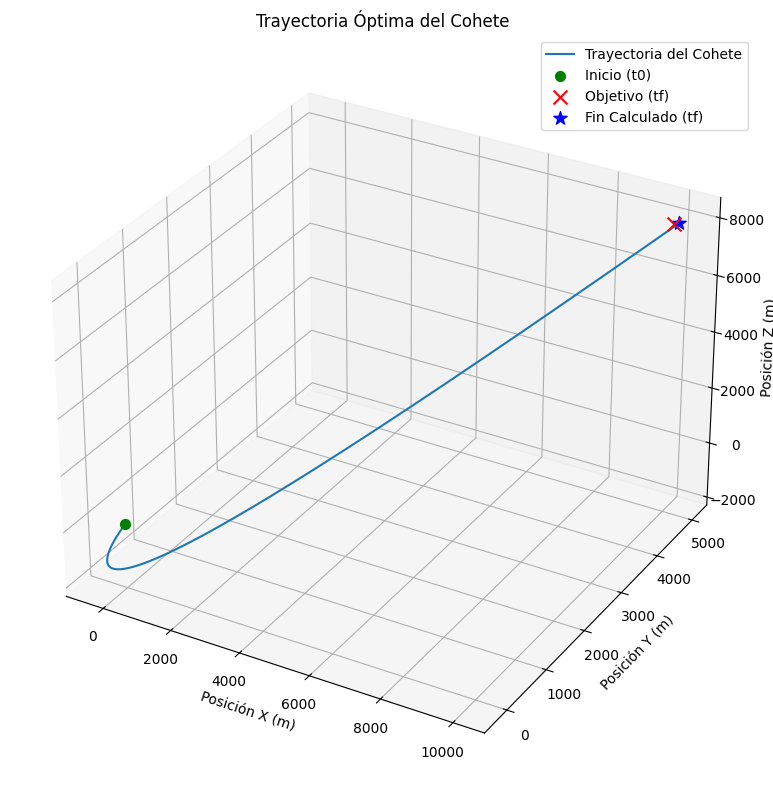

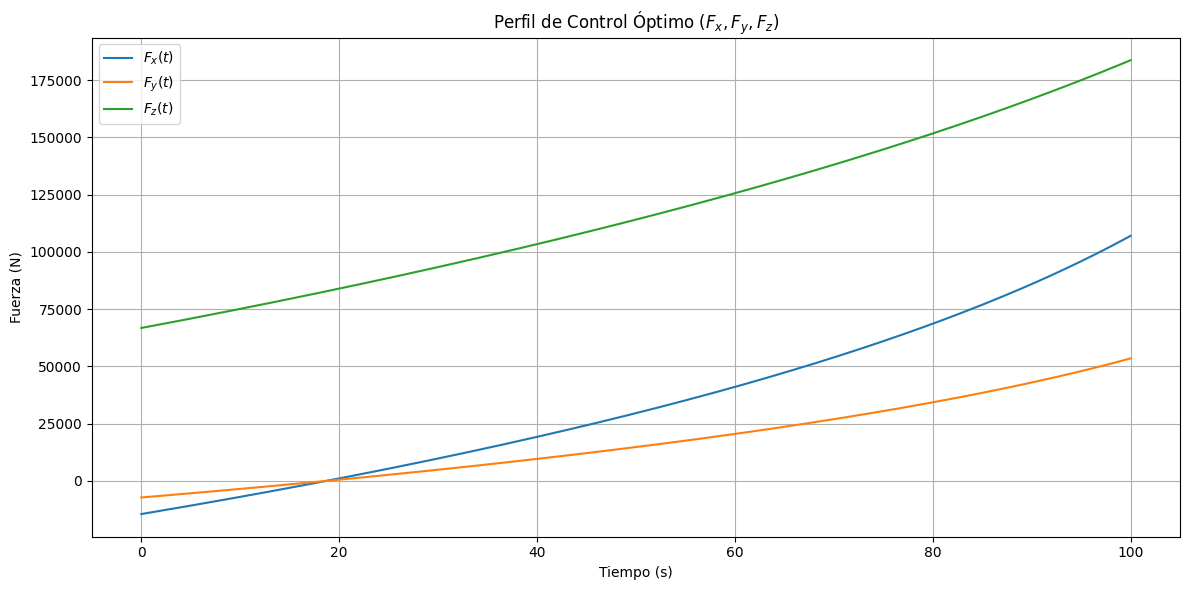

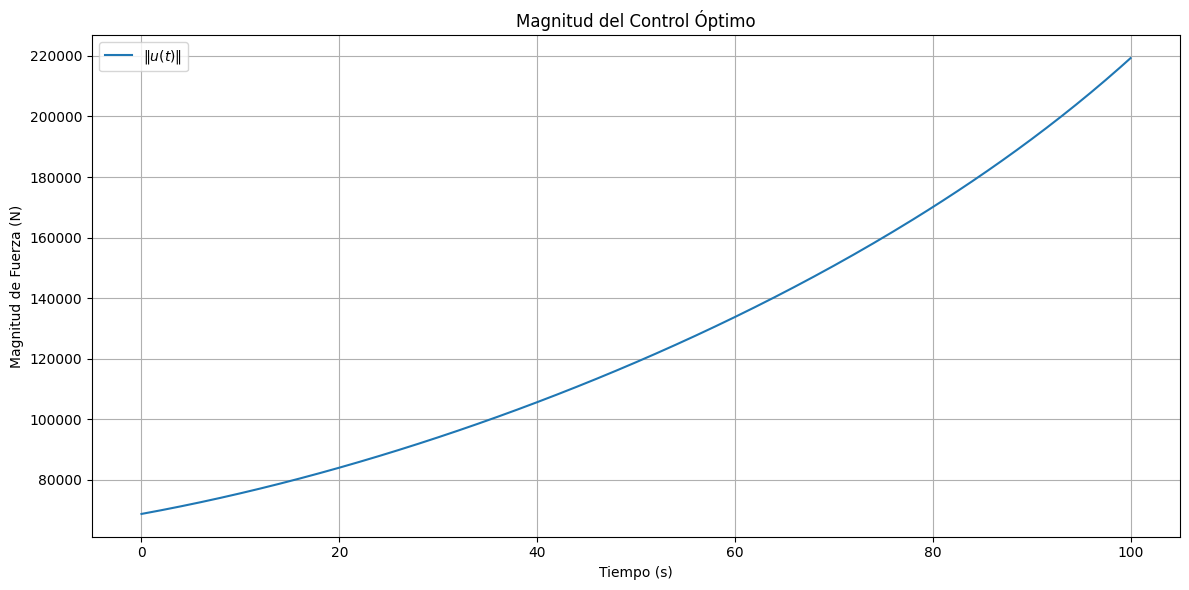

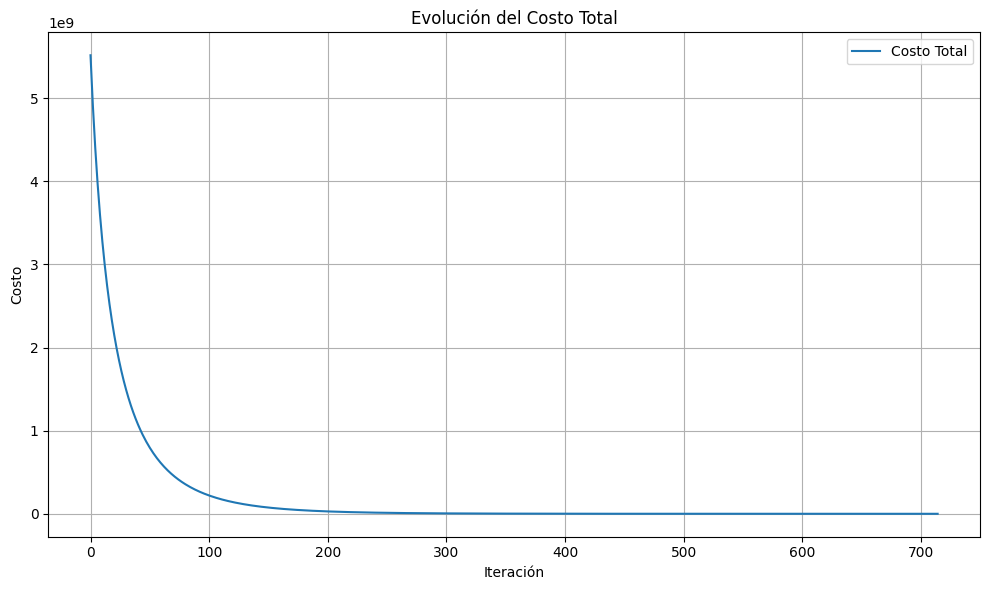

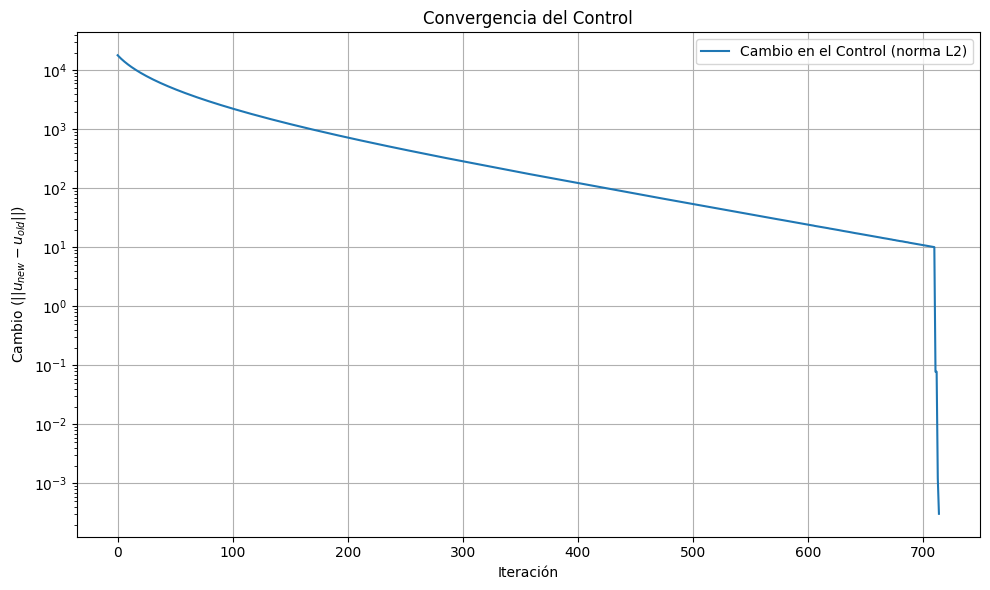

In [ ]:
# --- Visualizacion de Resultados ---

# Recalcular la trayectoria final con el control optimo encontrado
final_forward_sol = forward_pass(time_points, u_profile, [t0, tf])
final_x_trajectory = final_forward_sol.sol(time_points)

# Coordenadas finales
px_final, py_final, pz_final = final_x_trajectory[0, -1], final_x_trajectory[1, -1], final_x_trajectory[2, -1]
m_final = final_x_trajectory[6, -1]

print(f"\n--- Resultados Finales ---")
print(f"Posicion final calculada: ({px_final:.2f}, {py_final:.2f}, {pz_final:.2f})")
print(f"Posicion objetivo:       ({p_xF:.2f}, {p_yF:.2f}, {p_zF:.2f})")
print(f"Masa final del cohete: {m_final:.2f} kg")
print(f"Costo Total Final: {cost_history[-1]:.4f}")

# Graficar la trayectoria 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(final_x_trajectory[0, :], final_x_trajectory[1, :], final_x_trajectory[2, :], label='Trayectoria del Cohete')
ax.scatter(p_x0, p_y0, p_z0, color='green', marker='o', s=50, label='Inicio (t0)')
ax.scatter(p_xF, p_yF, p_zF, color='red', marker='x', s=100, label='Objetivo (tf)')
ax.scatter(px_final, py_final, pz_final, color='blue', marker='*', s=100, label='Fin Calculado (tf)')
ax.set_xlabel('Posicion X (m)')
ax.set_ylabel('Posicion Y (m)')
ax.set_zlabel('Posicion Z (m)')
ax.set_title('Trayectoria optima del Cohete')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


# Graficar las componentes de fuerza de control
plt.figure(figsize=(12, 6))
plt.plot(time_points, u_profile[:, 0], label='$F_x(t)$')
plt.plot(time_points, u_profile[:, 1], label='$F_y(t)$')
plt.plot(time_points, u_profile[:, 2], label='$F_z(t)$')
plt.xlabel('Tiempo (s)')
plt.ylabel('Fuerza (N)')
plt.title('Perfil de Control optimo ($F_x, F_y, F_z$)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Graficar la magnitud de la fuerza de control
magnitude_u = np.linalg.norm(u_profile, axis=1)
plt.figure(figsize=(12, 6))
plt.plot(time_points, magnitude_u, label='$\|u(t)\|$')
plt.xlabel('Tiempo (s)')
plt.ylabel('Magnitud de Fuerza (N)')
plt.title('Magnitud del Control optimo')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Graficar la evolucion del costo
plt.figure(figsize=(10, 6))
plt.plot(cost_history, label='Costo Total')
plt.xlabel('Iteracion')
plt.ylabel('Costo')
plt.title('Evolucion del Costo Total')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Graficar el cambio en el control (para ver la convergencia)
plt.figure(figsize=(10, 6))
plt.semilogy(control_change_history, label='Cambio en el Control (norma L2)')
plt.xlabel('Iteracion')
plt.ylabel('Cambio ($||u_{new} - u_{old}||$)')
plt.title('Convergencia del Control')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()